In [59]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
import numpy as np
from IPython.display import clear_output   # in order to clear the print output
import time

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')   # in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gradient Descent

In [60]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [61]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [62]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 40, tolerance=1e-6):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        W_old = W
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        if torch.all(torch.abs(W - W_old) <= tolerance):   return W
        W.requires_grad=True
    return W

# Histogram: link between initialization and the final result

In [6]:
# PR = non_local_boxes.utils.PR
# SR = non_local_boxes.utils.SR
# I = non_local_boxes.utils.I
# P = (PR + SR)/2
# # alpha=0.6
# # beta=0.3
# # P = alpha*PR +beta*SR + (1-alpha-beta)*I
# BoxProduct = non_local_boxes.evaluate.phi_flat
# n=non_local_boxes.evaluate.nb_columns
# histogram=[]

# N=100

# for i in range(N):
#     starting_W = non_local_boxes.utils.random_wiring(n)
#     W = gradient_descent(
#         starting_W=starting_W,
#         P=P,
#         Q=P,
#         learning_rate=0.1,
#         nb_iterations=150
#     )
#     histogram.append(float(BoxProduct(W, P, P)))

# plt.hist(histogram, bins=50)
# plt.xlabel("CHSH-value")
# plt.ylabel("Number of occurrences")
# plt.yscale("log")
# #plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
# plt.show()

0.8449999690055847
0.845


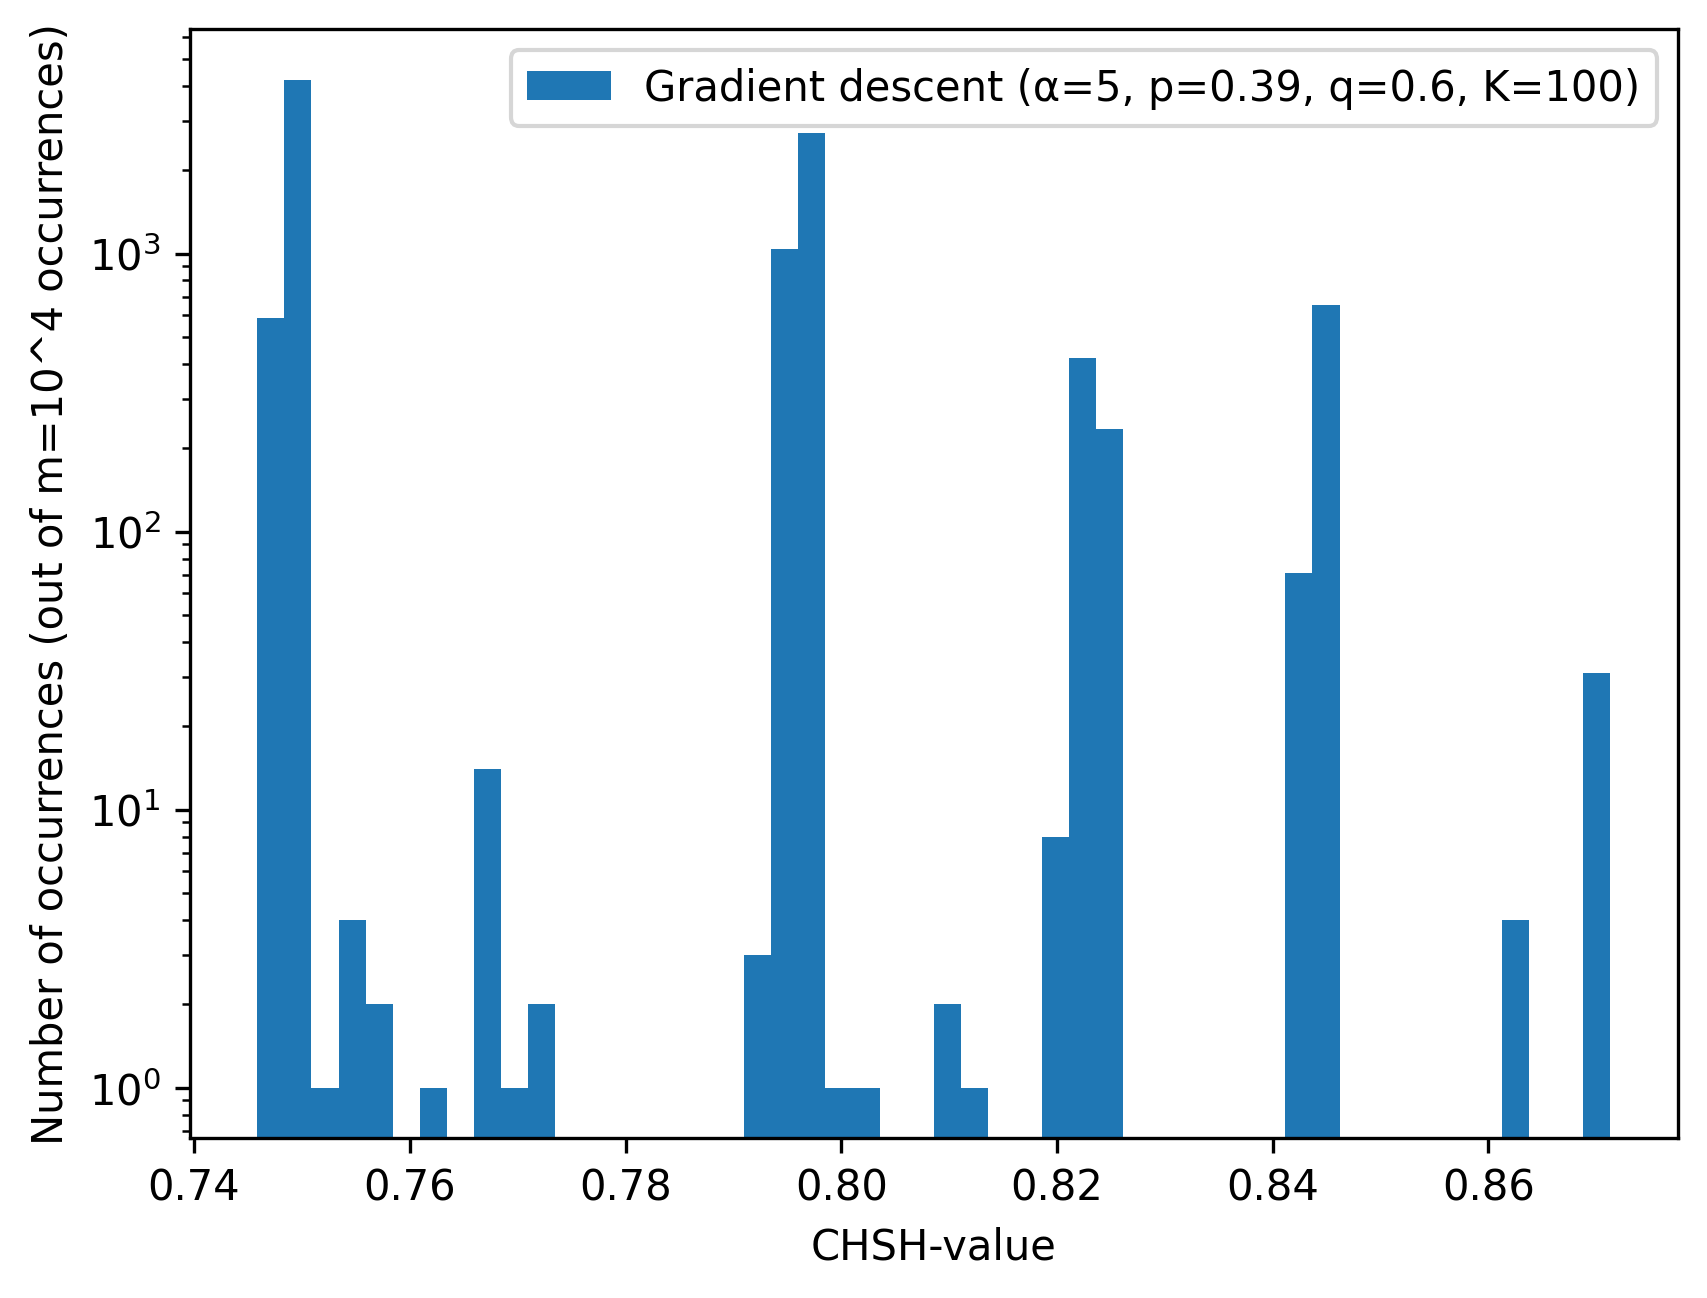

In [111]:
PR = non_local_boxes.utils.PR
SR = non_local_boxes.utils.SR
I = non_local_boxes.utils.I
# P = (PR + SR)/2
p=0.39
q=0.6
P = p*PR +q*SR + (1-p-q)*I
BoxProduct = non_local_boxes.evaluate.phi_flat
n=non_local_boxes.evaluate.nb_columns
starting_W = non_local_boxes.utils.random_wiring(n)
CHSH_value = non_local_boxes.evaluate.h_flat
print(float(CHSH_value(non_local_boxes.utils.matrix_to_tensor(P))))
print(p+q*(3/4)+(1-p-q)*(1/2))

alpha = 5
K=100

W = gradient_descent(
    starting_W=starting_W,
    P=P,
    Q=P,
    learning_rate=alpha,
    nb_iterations=K
)
histogramGD = BoxProduct(W, P, P).tolist()

plt.hist(histogramGD, bins=50, label="Gradient descent (α="+str(alpha)+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
plt.xlabel("CHSH-value")
plt.ylabel("Number of occurrences (out of m=10^"+str(int(np.log10(n)))+" occurrences)")
plt.yscale("log")
plt.legend()
#plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
plt.show()

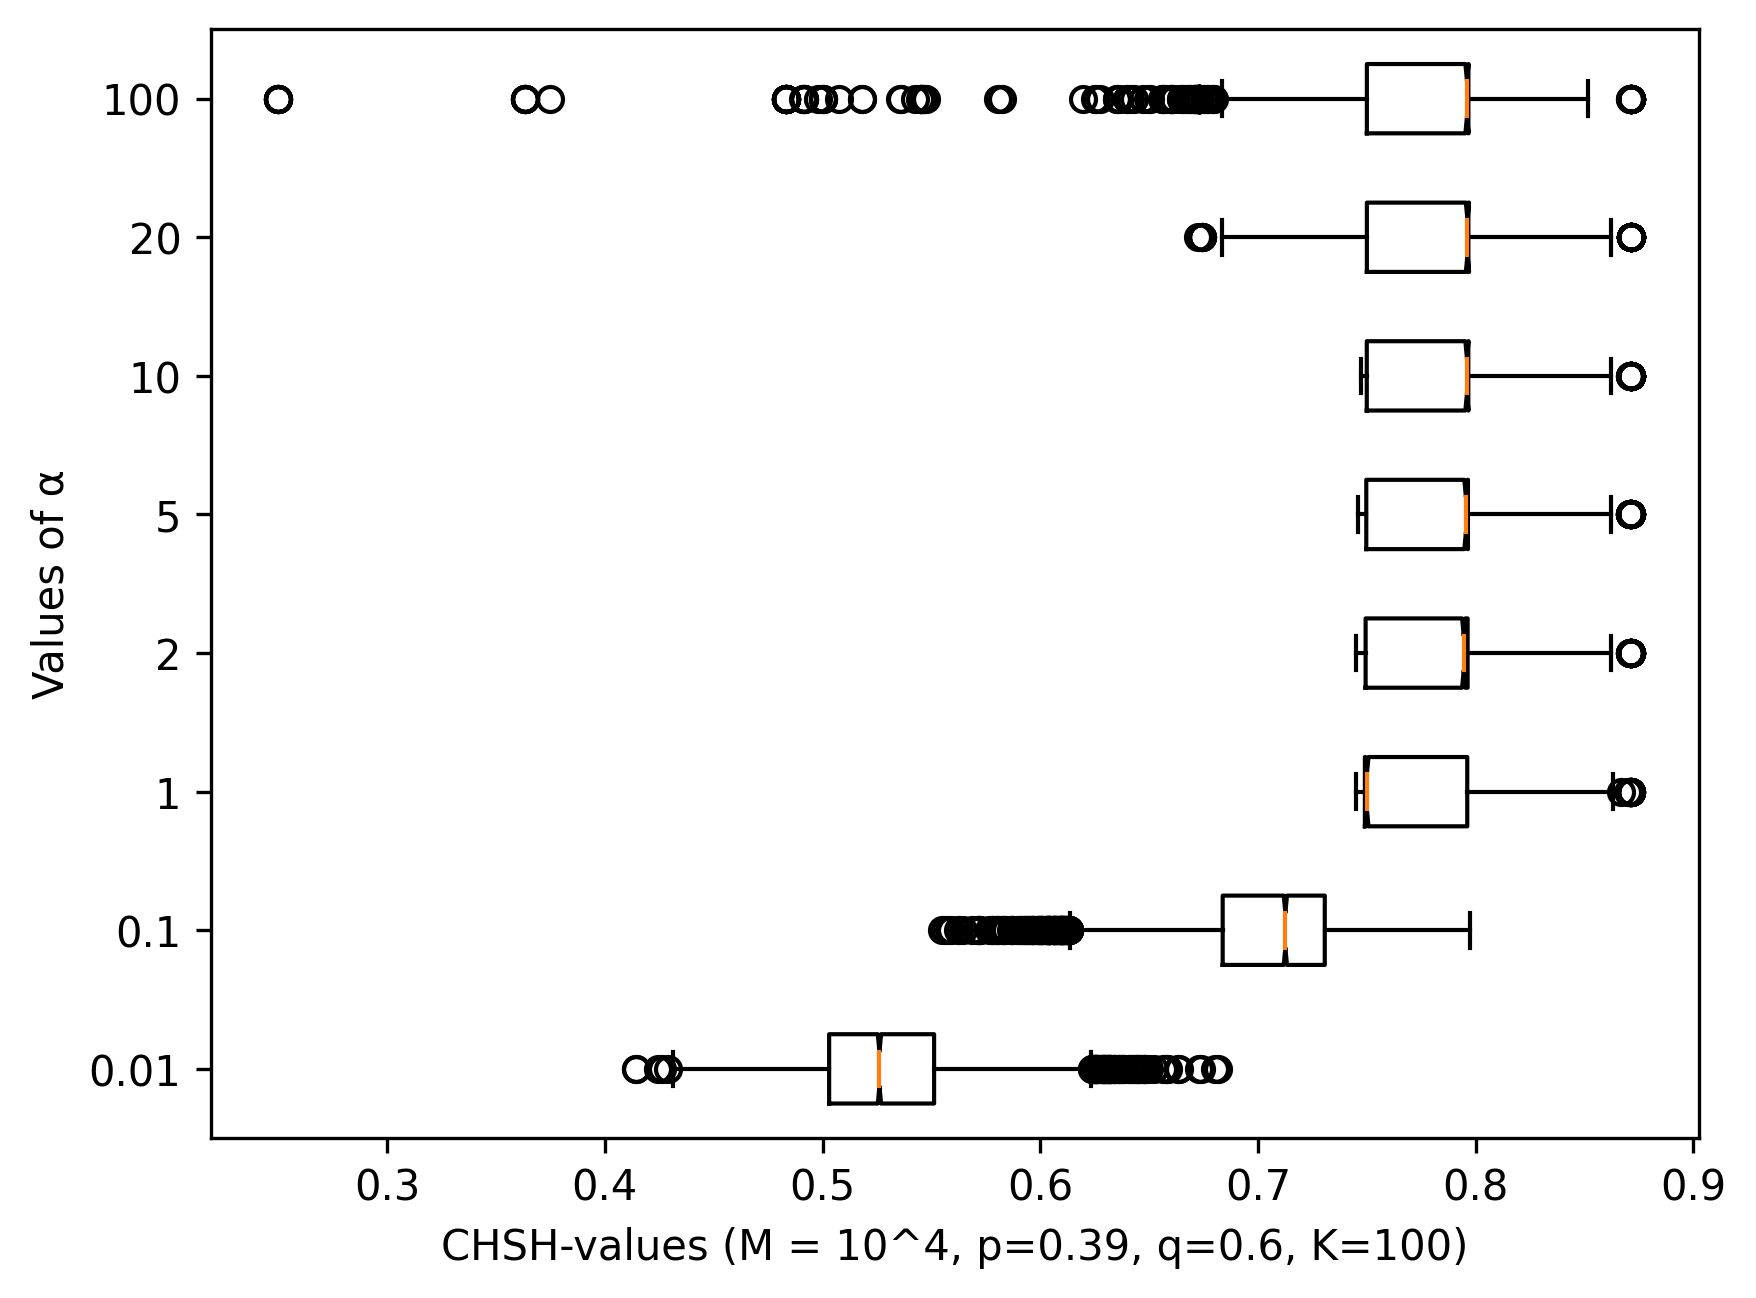

In [112]:
# PR = non_local_boxes.utils.PR
# SR = non_local_boxes.utils.SR
# I = non_local_boxes.utils.I
# P = (PR + SR)/2
alpha_list = [0.01, 0.1, 1, 2, 5, 10, 20, 100]
histogramGD = []
for alpha in alpha_list:
    W = gradient_descent(
        starting_W=starting_W,
        P=P,
        Q=P,
        learning_rate=alpha,
        nb_iterations=K
    )
    histogramGD.append(BoxProduct(W, P, P).tolist())

plt.boxplot(histogramGD, notch=True, vert=False, labels=[str(i) for i in alpha_list])
plt.xlabel("CHSH-values (M = 10^"+str(int(np.log10(n)))+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
plt.ylabel("Values of α")
plt.show()

# Test Heavy Ball

$$u_{k+1} = \mathtt{proj}\big(u_k - \alpha \nabla f(u_k) + \underbrace{\beta(u_k - u_{k-1})}_{\text{momentum}}\big)$$

In [10]:
def heavy_ball(starting_W, P, Q, learning_rate = 2, beta=1, nb_iterations = 40, tolerance=1e-6):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        W_old = W
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad + beta*(W-W_old)).detach()  # create a brand new tensor, forgeting the previous gradient
        if torch.all(torch.abs(W - W_old) <= tolerance):   return W
        W.requires_grad=True
    return W

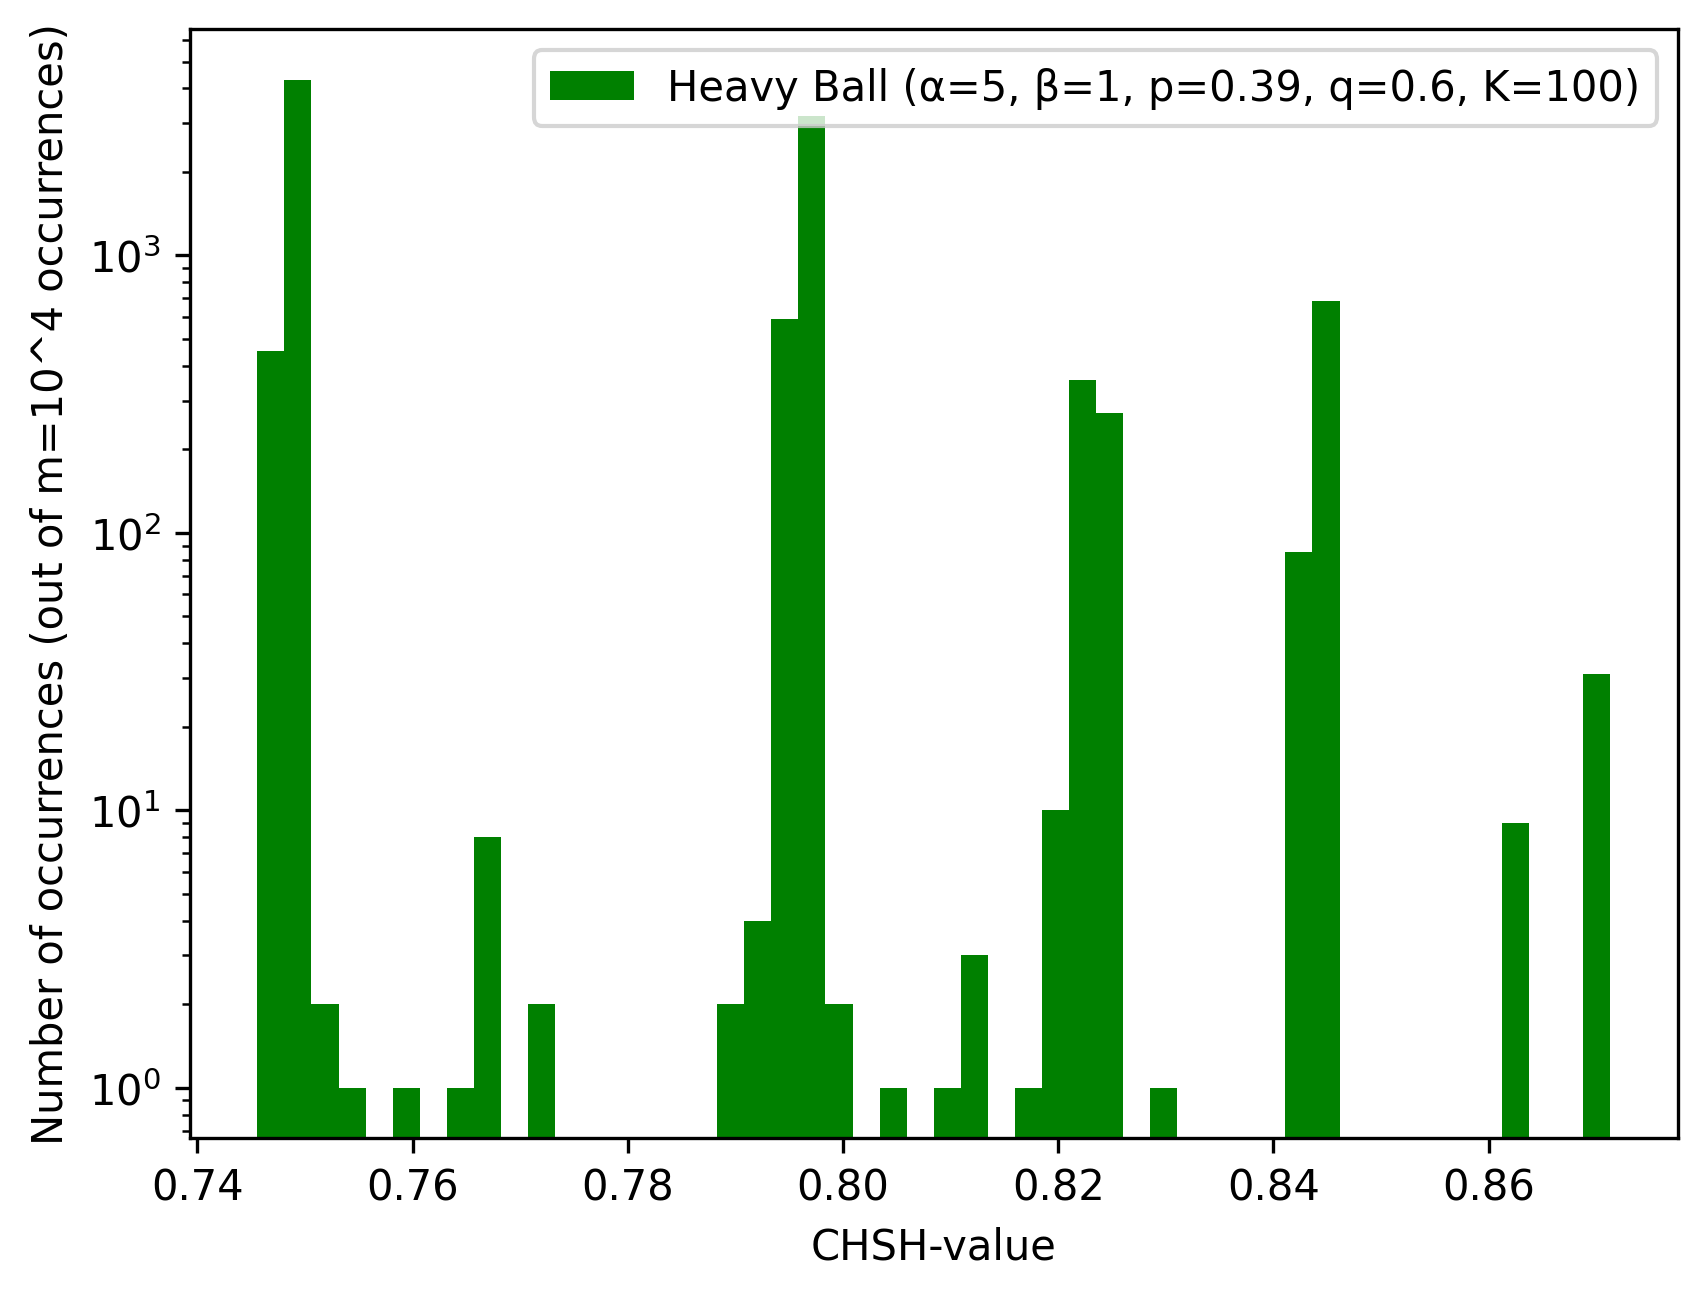

In [113]:
n=non_local_boxes.evaluate.nb_columns
starting_W = non_local_boxes.utils.random_wiring(n)

alpha = 5
beta = 1

W = heavy_ball(
    starting_W=starting_W,
    P=P,
    Q=P,
    learning_rate=alpha,
    beta = beta,
    nb_iterations=K,
    tolerance=1e-6
)
histogramHB = BoxProduct(W, P, P).tolist()

plt.hist(histogramHB, bins=50, color='green', label="Heavy Ball (α="+str(alpha)+", β="+str(beta)+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
plt.xlabel("CHSH-value")
plt.ylabel("Number of occurrences (out of m=10^"+str(int(np.log10(n)))+" occurrences)")
plt.yscale("log")
plt.legend()
#plt.title("Histogram of the different results with a random initialization (with $\mathbf{P}=(\mathbf{PR}+\mathbf{SR})/2$, total: "+str(N)+" occurences)")
plt.show()

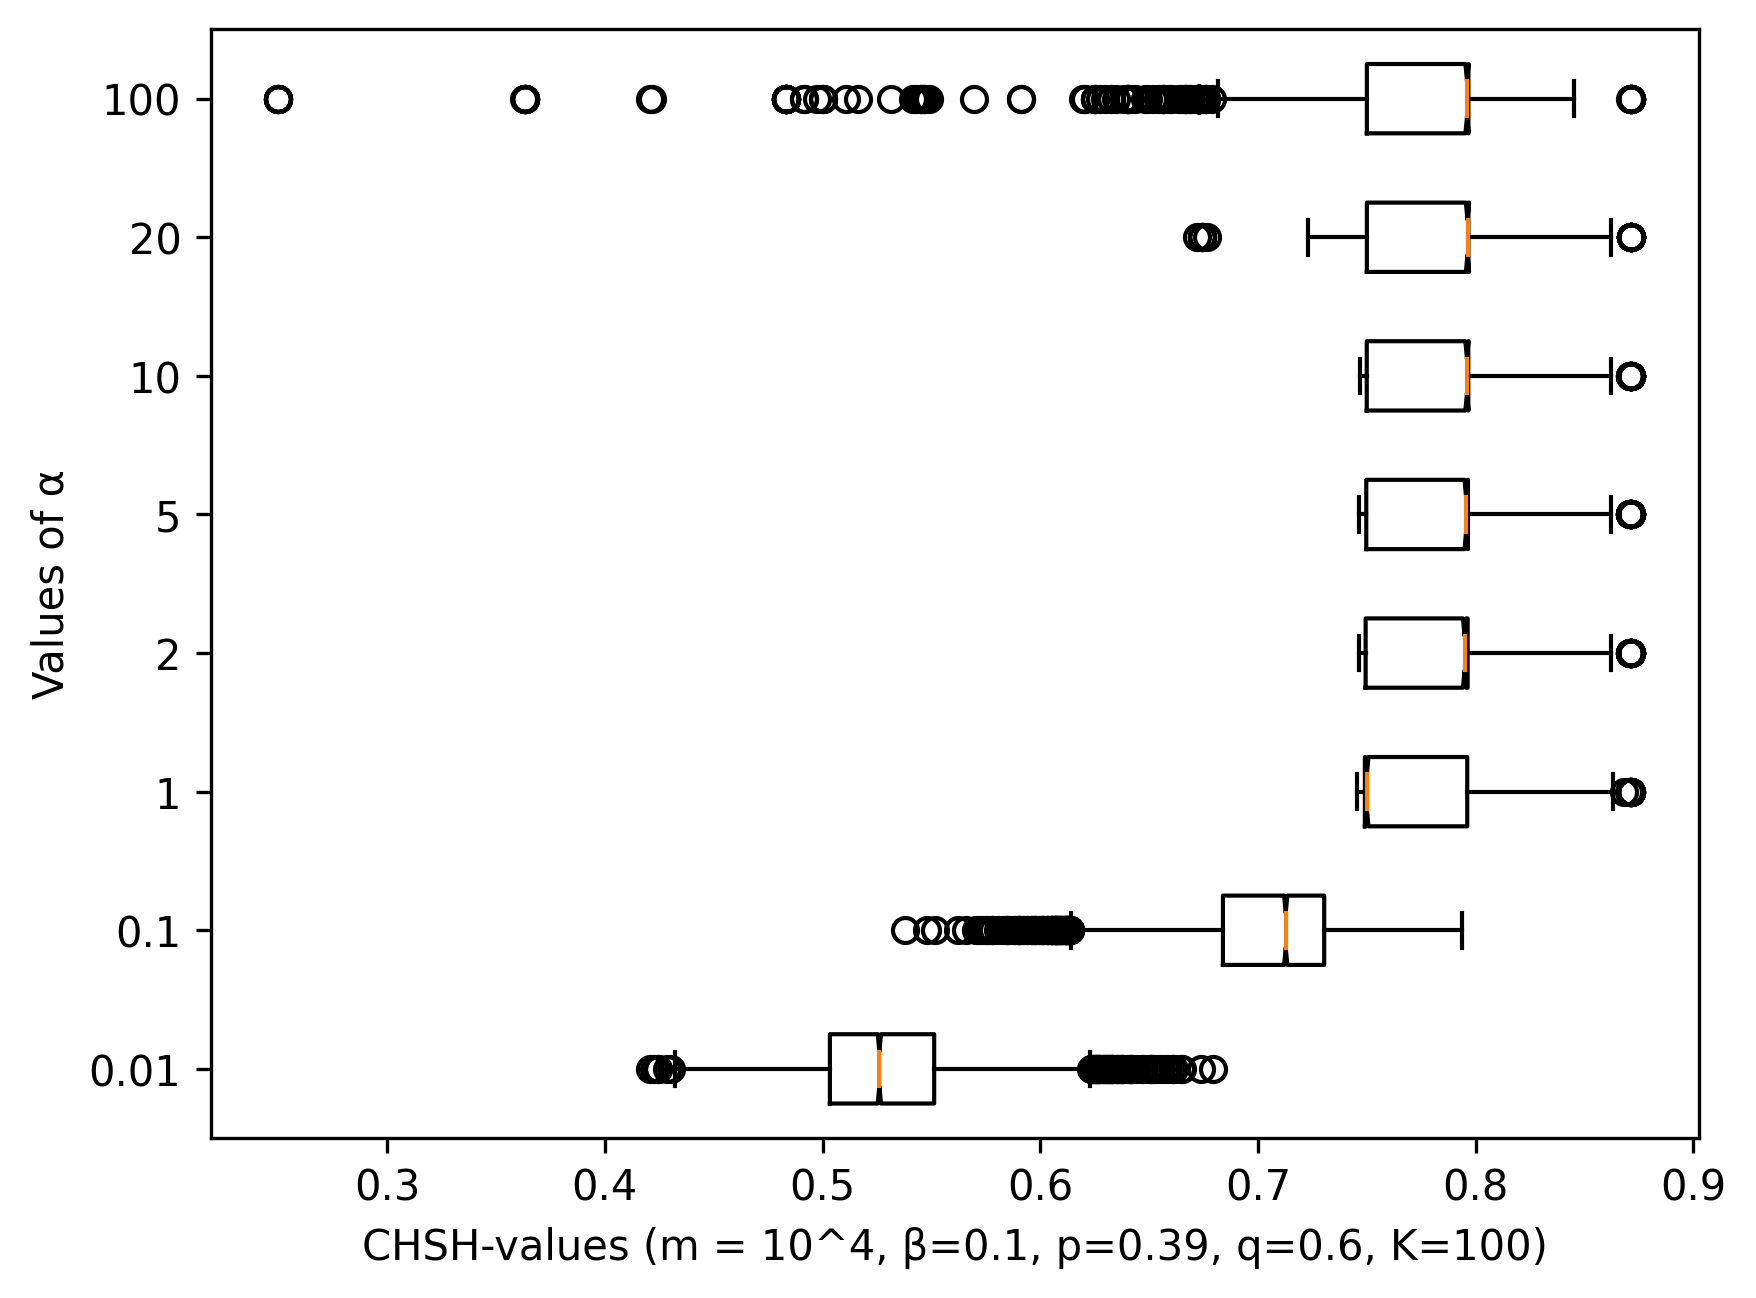

In [114]:
alpha_list = [0.01, 0.1, 1, 2, 5, 10, 20, 100]
histogramHB = []
beta = 0.1
for k in alpha_list:
    W = heavy_ball(
        starting_W=starting_W,
        P=P,
        Q=P,
        learning_rate=k,
        beta = beta,
        nb_iterations=K,
        tolerance=1e-6
    )
    histogramHB.append(BoxProduct(W, P, P).tolist())

plt.boxplot(histogramHB, notch=True, vert=False, labels=[str(i) for i in alpha_list])
plt.xlabel("CHSH-values (m = 10^"+str(int(np.log10(n)))+", β="+str(beta)+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
plt.ylabel("Values of α")
plt.show()

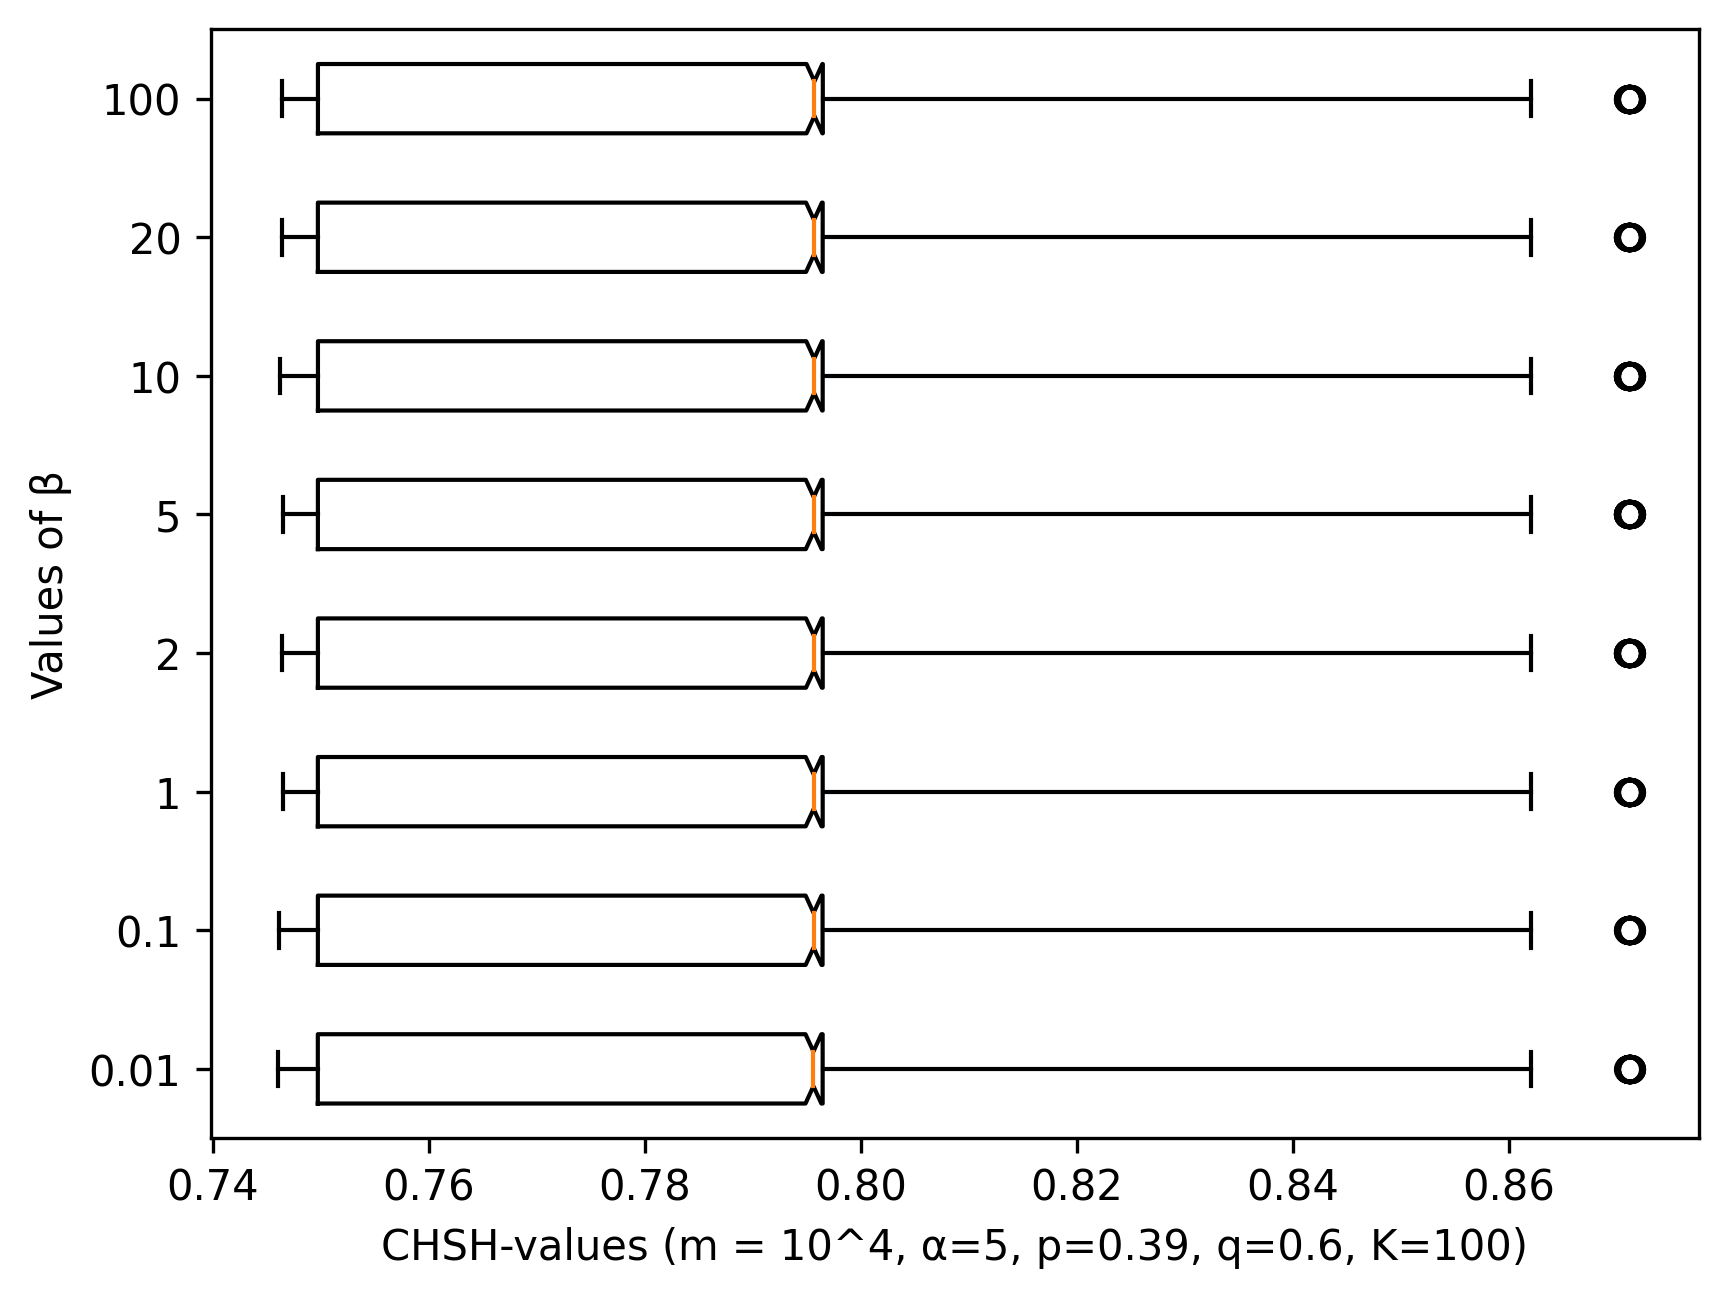

In [115]:
beta_list = [0.01, 0.1, 1, 2, 5, 10, 20, 100]
histogramHB = []
alpha = 5
for k in beta_list:
    W = heavy_ball(
        starting_W=starting_W,
        P=P,
        Q=P,
        learning_rate=alpha,
        beta = k,
        nb_iterations=K,
        tolerance=1e-6
    )
    histogramHB.append(BoxProduct(W, P, P).tolist())

plt.boxplot(histogramHB, notch=True, vert=False, labels=[str(i) for i in beta_list])
plt.xlabel("CHSH-values (m = 10^"+str(int(np.log10(n)))+", α="+str(alpha)+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
plt.ylabel("Values of β")
plt.show()

## Comparison

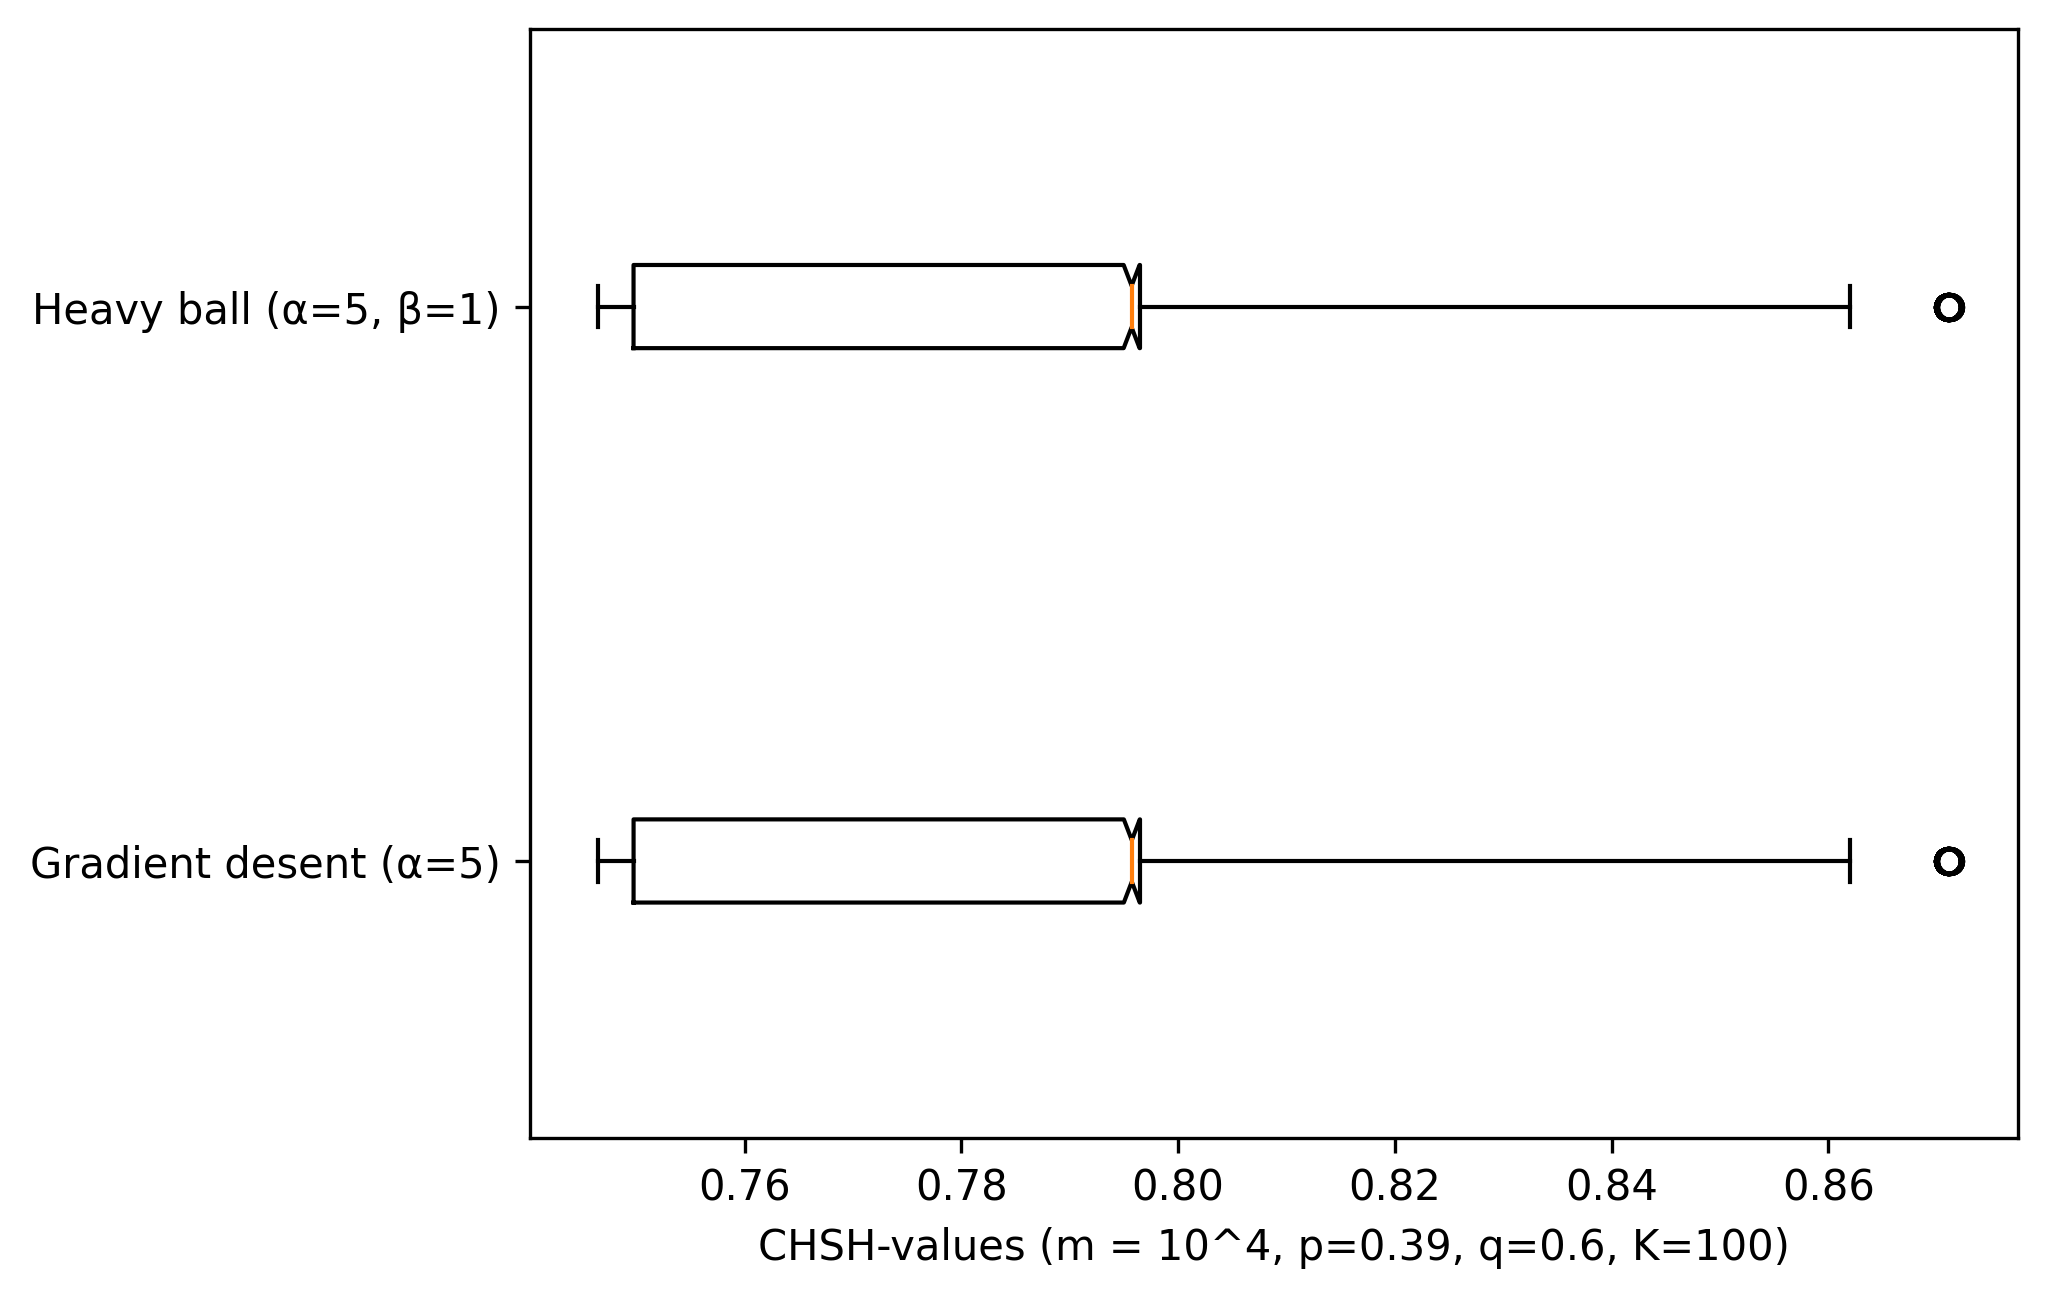

In [116]:
# PR = non_local_boxes.utils.PR
# SR = non_local_boxes.utils.SR
# I = non_local_boxes.utils.I
# P = (PR + SR)/2

histograms = []
K = 100

alphaGD = 5
W = gradient_descent(
    starting_W=starting_W,
    P=P,
    Q=P,
    learning_rate=alphaGD,
    nb_iterations=K
)
histograms.append(BoxProduct(W, P, P).tolist())

alphaHB = 5
betaHB = 1
W = heavy_ball(
        starting_W=starting_W,
        P=P,
        Q=P,
        learning_rate=alphaHB,
        beta = betaHB,
        nb_iterations=K,
        tolerance=1e-6
    )
histograms.append(BoxProduct(W, P, P).tolist())

list = [
    "Gradient desent (α="+str(alphaGD)+")",
    "Heavy ball (α="+str(alphaHB)+", β="+str(betaHB)+")"
    ]

plt.boxplot(histograms, notch=True, vert=False, labels=list)
plt.xlabel("CHSH-values (m = 10^"+str(int(np.log10(n)))+", p="+str(p)+", q="+str(q)+", K="+str(K)+")")
#plt.ylabel("Values of α")
plt.show()

# Speed comparison: "for loop" VS "in parallel"

In [73]:
# !!!!! Set nb_columns = 1 !!!!!

n = non_local_boxes.evaluate.nb_columns
starting_W = non_local_boxes.utils.random_wiring(n)
print("nb_columns =",n)
N = 100
alpha = 5
p = 0.39
q = 0.6
P = p*PR +q*SR + (1-p-q)*I

list_n = [2**k for k in range(11)]
timingGD = []
for n in list_n:
    print("n =", n)
    start = time.time()
    for k in range(n):
        gradient_descent(
            starting_W=starting_W,
            P=P,
            Q=P,
            learning_rate=alpha,
            nb_iterations=N
        )
    end = time.time()
    timingGD.append(end - start)

print(timingGD)

nb_columns = 1
n = 1
n = 2
n = 4
n = 8
n = 16
n = 32
n = 64
n = 128
n = 256
n = 512
n = 1024
[0.1540839672088623, 0.2853429317474365, 0.4467349052429199, 0.7373979091644287, 1.0526928901672363, 4.493952989578247, 9.30904507637024, 13.854564905166626, 36.367050886154175, 73.95716619491577, 149.1262719631195]


In [74]:
# !!!!! Set nb_columns = 2**k, by hand for k in range(11) !!!!!
timingParall = []

In [86]:
n = non_local_boxes.evaluate.nb_columns
starting_W = non_local_boxes.utils.random_wiring(n)
print("nb_columns =",n)

print("in order to load the package:",non_local_boxes.evaluate.phi_flat(starting_W, P, P))

start = time.time()
gradient_descent(
    starting_W=starting_W,
    P=P,
    Q=P,
    learning_rate=alpha,
    nb_iterations=N
)
end = time.time()
timingParall.append(end - start)

print(timingParall)

nb_columns = 1024
in order to load the package: tensor([0.5436, 0.4969, 0.4844,  ..., 0.5035, 0.5580, 0.4755],
       grad_fn=<ReshapeAliasBackward0>)
[0.1428227424621582, 0.1543259620666504, 0.15115809440612793, 0.16815590858459473, 0.1935429573059082, 0.19485902786254883, 0.2525601387023926, 0.41300392150878906, 0.5318670272827148, 0.7136580944061279, 1.0403170585632324]


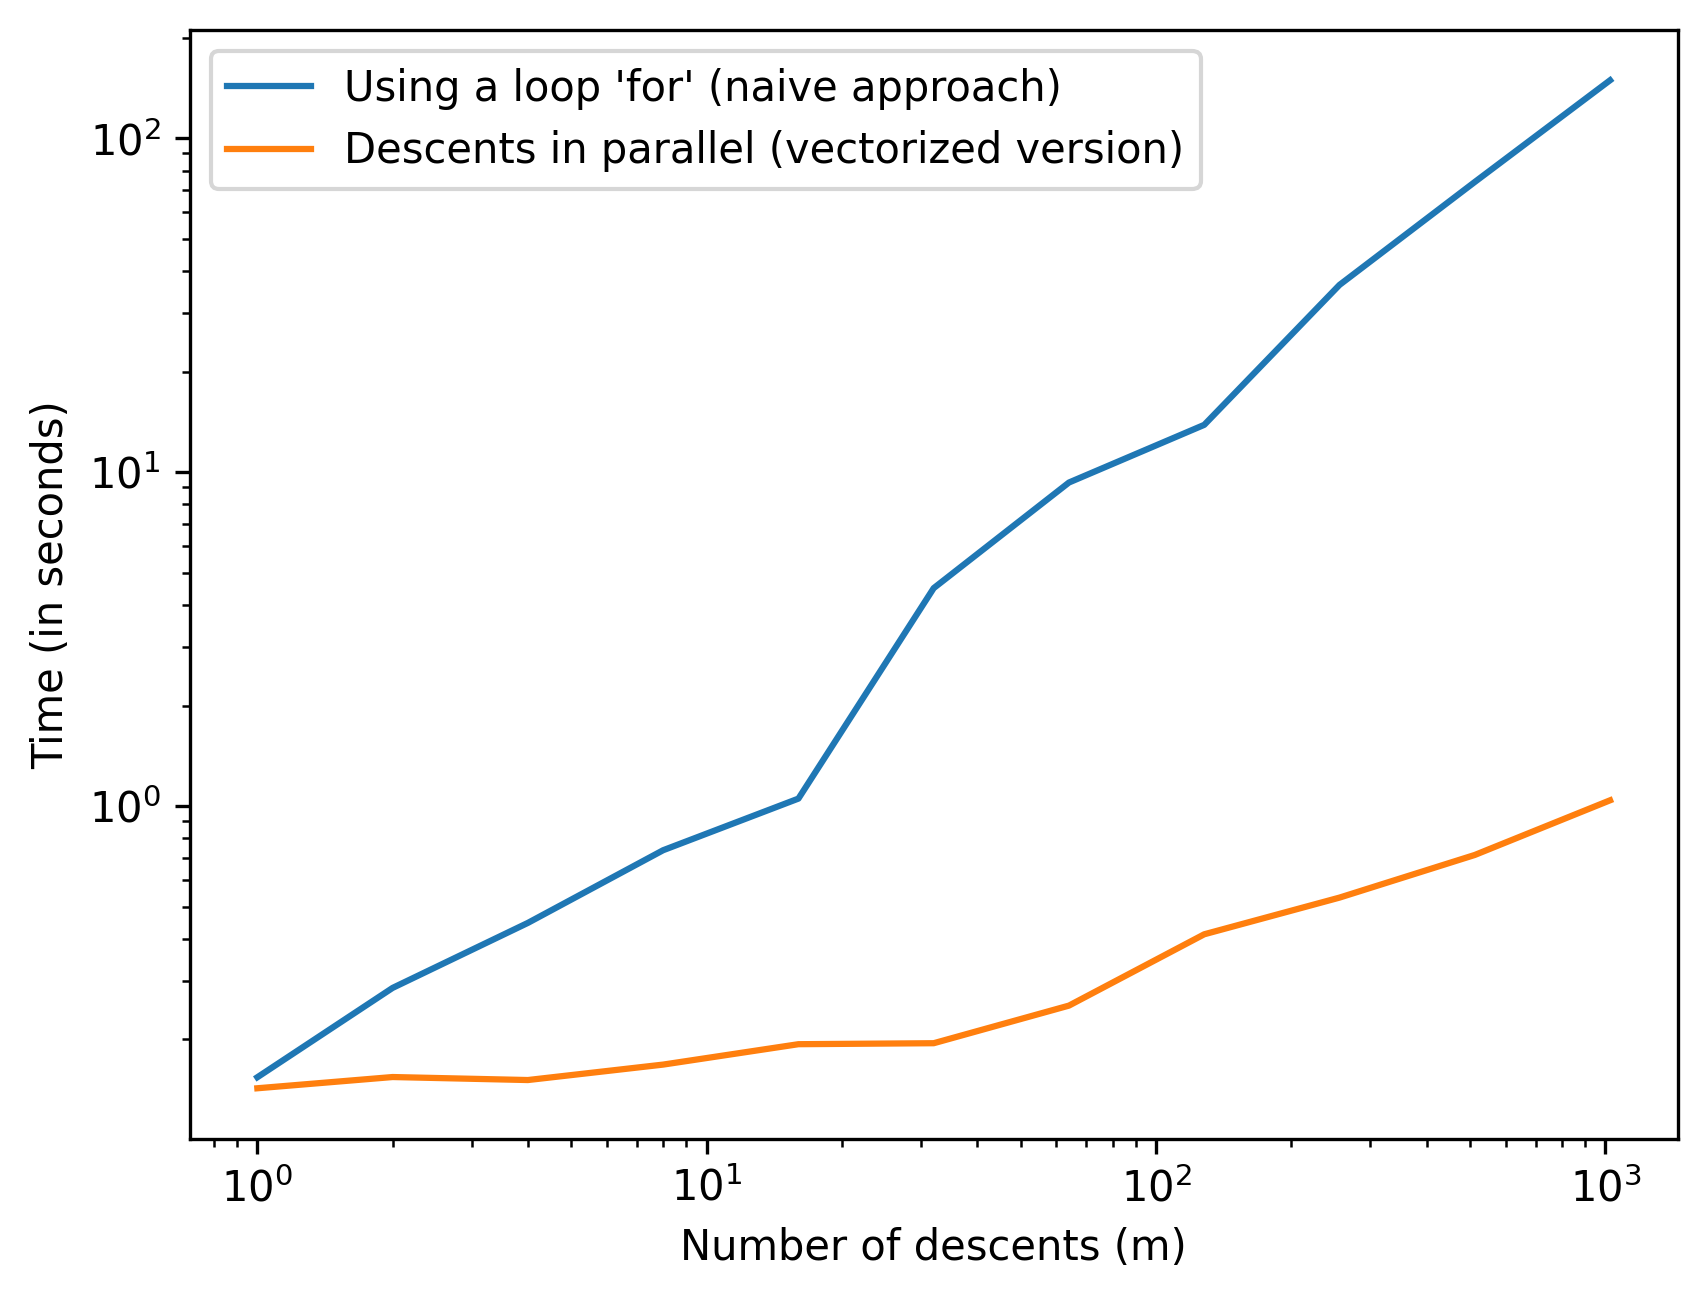

In [110]:
plt.figure()
plt.plot(list_n, timingGD, label="Using a loop 'for' (naive approach)")
plt.plot(list_n, timingParall, label="Descents in parallel (vectorized version)")
plt.legend()
plt.loglog()
plt.xlabel("Number of descents (m)")
plt.ylabel("Time (in seconds)")
plt.show()

# Test in some triangle

In [ ]:
def new_color(value, threshold, k, max_box_power_GD):
    if value > threshold:
        return (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return "orangered"

In [ ]:
def next_Q(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        color_point = new_color(value, threshold, k, max_box_power_GD)
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, color_point

In [ ]:
def test_box_power(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        color_point = new_color(value, threshold, k, max_box_power_GD)

    return color_point

In [ ]:
def draw_triangle(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Box is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            color_point = new_color(value, threshold, 0, max_box_power_GD)
            best_wiring = non_local_boxes.utils.random_wiring(n)

            for k in range(max_box_power_GD-1):
                Q, best_wiring, color_point = next_Q(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold)
                color_point = test_box_power(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold)

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 2,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# Naive test in some triangle

In [ ]:
def draw_triangle_naive(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    W_random = non_local_boxes.utils.random_wiring(n)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))

            if value > threshold:
                color_point = (0, 0.1, 0.1)
                #print(value)
            else:
                # Given a box P, we look for the W maximizing P x_W P
                W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
                list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
                index, value = max(enumerate(list), key=lambda x: x[1])
                best_wiring = W[:,index].detach()
                best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
                #print(value)
                
                for k in range(max_box_power+1):
                    if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                        color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                        break
                    Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_naive(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power = 50,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# With blue cones: it's dangerous because the triangle is not stable under all wirings

We check if the starting box $P$ is a in the blue cone of another box, but we don't check the powers of $P$ because they could be outside of the triangle.

In [ ]:
def is_in_a_blue_cone(xP, yP, blue_points, X): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point in blue_points:
        x0, y0 = point
        f = lambda x : X[1,1]*(x-x0)/(X[1,0]-x0) + y0*(x-X[1,0])/(x0-X[1,0])  # Lagrange interpolation
        g = lambda x : X[2,1]*(x-x0)/(X[2,0]-x0) + y0*(x-X[2,0])/(x0-X[2,0])  # Lagrange interpolation
        if yP <= f(xP) and yP >= g(xP):
            return True
    return False

In [ ]:
def new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD):
    if value > threshold:
        blue_points.append((xP,yP))
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [ ]:
def next_Q_with_blue_cones(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [ ]:
def test_box_power_with_blue_cones(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)

    return blue_points, color_point

In [ ]:
def draw_triangle_with_blue_cones(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            if is_in_a_blue_cone(xP, yP, blue_points, X):
                color_point = (0, 0.1, 0.1)
            else:
                Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                value = float(non_local_boxes.evaluate.h_flat(Q))
                blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                best_wiring = non_local_boxes.utils.random_wiring(n)

                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                    blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_with_blue_cones(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 10,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

# With the rerun option

We run again the gradient descent, but we keep the list `blue_points`.

In [ ]:
def draw_triangle_with_rerun(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            for j in range(box_grid_size-i+1):
                alpha, beta = i/box_grid_size, j/box_grid_size
                xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
                P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
                color_point = "orangered"

                if is_in_a_blue_cone(xP, yP, blue_points, X):
                    color_point = (0, 0.1, 0.1)
                else:
                    Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                    best_wiring = non_local_boxes.utils.random_wiring(n)

                    for k in range(max_box_power_GD-1):
                        Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                        blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

                plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [ ]:
"""draw_triangle_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 3
)"""

# Draw segment

In [ ]:
def is_in_a_blue_cone_1D(value, blue_points): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point_value in blue_points:
        if value>=point_value:
            return True
    return False

In [ ]:
def new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W):
    if value > threshold:
        blue_points.append(valueP)
        if W!= "No wiring":
            print(non_local_boxes.utils.projection_to_extremal_wiring(W).detach())
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [ ]:
def next_Q_1D(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, best_wiring[:,0])
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [ ]:
def test_box_power_1D(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W0[:,0])

    return blue_points, color_point

In [ ]:
def draw_segment_with_rerun(Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    if n != 10000:
        return "WARNING: please change the number of wirings to 10,000."
    
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for run in range(rerun_count):
        #clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            alpha = i/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha)
            P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            valueP = float(non_local_boxes.evaluate.h_flat(Q))
            value = valueP
            #print(value)
            blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, 0, max_box_power_GD, "No wiring")
            best_wiring = non_local_boxes.utils.random_wiring(n)

            if is_in_a_blue_cone_1D(value, blue_points):
                color_point = (0, 0.1, 0.1)
            else:
                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_1D(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP)
                    blue_points, color_point = test_box_power_1D(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()

# Test a wiring in a segment and in a triangle

In [ ]:
def test_wiring_segment(W, Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        alpha = i/box_grid_size
        P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
        color_point = "orangered"

        Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
        value = float(non_local_boxes.evaluate.h_flat(Q))
        # print(value)
        if value > threshold:
                color_point = (0, 0.1, 0.1)
        else:
            if value != 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

        plt.plot(X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()


In [ ]:
def test_wiring_triangle(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            #print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                #if value > 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

## Test

In [ ]:
# W = torch.tensor([0., 0., 1., 1.,              # f_1(x, a_2) = x
#             0., 0., 1., 1.,              # g_1(y, b_2) = y
#             0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
#             0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
#             0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
#             0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
#             ])

# # Set the number of wirings to 1

# test_wiring_triangle(
#     W = W,
#     Box1=non_local_boxes.utils.PR,
#     Box1_name = "PR",
#     Box2=non_local_boxes.utils.P_0,
#     Box2_name = "$P_0$",
#     Box3=non_local_boxes.utils.P_1,
#     Box3_name = "$P_1$",
#     box_grid_size = 60,
#     max_box_power = 15,
#     threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
# )

# Let's go

In [ ]:
PR = non_local_boxes.utils.PR
PL = non_local_boxes.utils.P_L
PNL = non_local_boxes.utils.P_NL

In [ ]:
# Set the number of wirings to 10 000

draw_segment_with_rerun(
    Box1=PR,
    Box1_name = "PR",
    Box2=PL(0,0,0,0),
    Box2_name = "$P_0$",
    box_grid_size = 40,   # 40
    max_box_power_GD = 10,  #10
    max_box_power = 35,  # 35
    learning_rate = 2,   # 2
    nb_iterations = 50,  #40
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 5
)

---
---
---
---
---
---
---
---

Use `Test-Wiring.ipynb` instead of the following.

In [ ]:
# Set the number of wirings to 1

W_result = torch.tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.])*1.0
W_result

In [ ]:
known_collapsing_W = non_local_boxes.utils.known_collapsing_W

print(len(known_collapsing_W))

for i in range(len(known_collapsing_W)):
    if torch.all(W_result == torch.tensor(known_collapsing_W[i])):
        print(" !!!  This wiring is already known: the",i+1,"th one.  !!!")
        assert(False)
print("-- Finished --")


In [ ]:
# Set the number of wirings to 1

test_wiring_segment(
    W = W_result,
    Box1=PR,
    Box1_name = "PR",
    Box2=PL(0,0,0,0),
    Box2_name = "$P_L^{0000}$",
    box_grid_size = 60,
    max_box_power = 1000,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

In [ ]:
boxes_to_be_tested = non_local_boxes.utils.boxes_to_be_tested

if non_local_boxes.evaluate.nb_columns != 1:
    print("WARNING: please change the number of wirings to 1.")
    assert(False)

for box_number in boxes_to_be_tested:
    mu, nu, sigma, tau = box_number
    test_wiring_triangle(
        W = W_result,
        Box1=PR,
        Box1_name = "PR",
        Box2=PL(0,0,0,0),
        Box2_name = "$P_0$",
        Box3=PL(mu,nu,sigma,tau),
        Box3_name = "$P_{L}$"+str(mu)+str(nu)+str(sigma)+str(tau),
        box_grid_size = 60,
        max_box_power = 20,
        threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
    )

In [ ]:
W_result

In [ ]:
if non_local_boxes.evaluate.nb_columns != 1:
    print("WARNING: please change the number of wirings to 1.")
    assert(False)

test_wiring_triangle(
        W = W_result,
        Box1=PR,
        Box1_name = "PR",
        Box2=PL(0,0,0,0),
        Box2_name = "$P_0$",
        Box3=(PR + non_local_boxes.utils.PRprime)/2,
        Box3_name = "(PR+PR')/2",
        box_grid_size = 60,
        max_box_power = 20,
        threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
    )